------------------------------------------------------------
KHSE hourly span: 1957-03-01 05:00:00+00:00 to 2025-08-27 02:00:00+00:00 n= 600382
Valid KHSE hours: 507261
------------------------------------------------------------
CO-OPS hourly span: 2010-04-28 14:00:00+00:00 to 2025-12-23 16:00:00+00:00 n= 137235
Valid CO-OPS hours: 136054
------------------------------------------------------------
Overlap pairs for transfer: 115342
Overlap span: 2010-04-28 14:00:00+00:00 to 2025-08-27 02:00:00+00:00
Transfer function (COOPS -> KHSE) on [u,v]:
A =
 [[ 0.72592491  0.15555487]
 [-0.05204697  0.65524304]]
b = [0.22283011 0.71680521]

Overlap diagnostics:
corr(u): 0.9285467869320696
corr(v): 0.9253802557756184
corr(U): 0.7513904145965682
------------------------------------------------------------

Hourly completeness:
KHSE present hours   : 507261 of 603228
Merged present hours : 527973 of 603228
Hours filled from COOPS: 20712

Largest KHSE gap (h): 626.0
Largest merged gap (h): 125.0

K

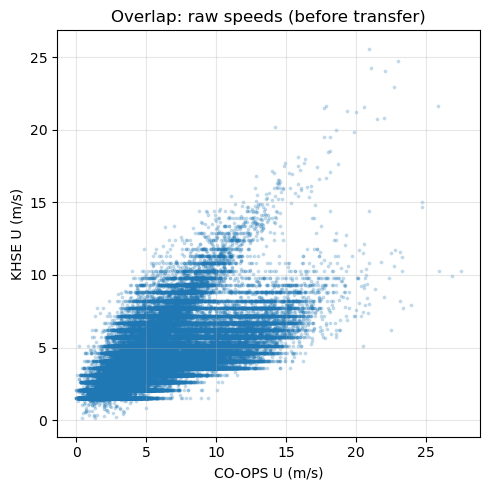

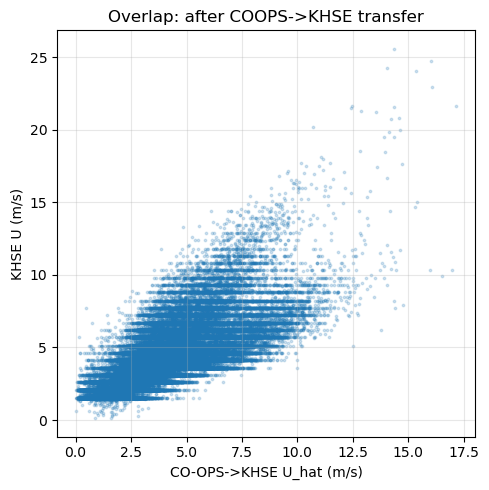

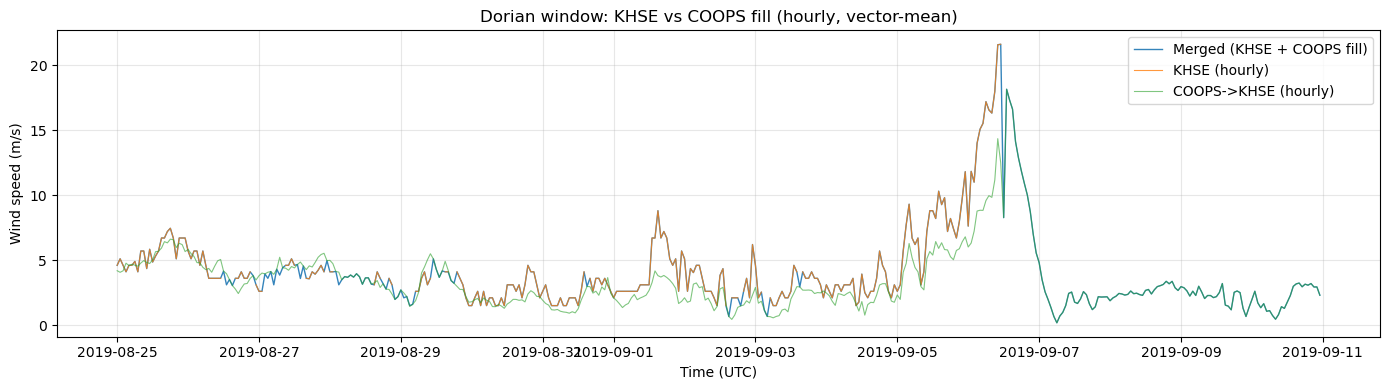


Wrote merged wind dataset:
F:\crs\src\Dorian_recovery\KHSE_wind_merged_with_COOPS_fill_hourly.csv


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ============================================================
# USER SETTINGS
# ============================================================
KHSE_WIND_CSV  = "isd_KHSE_only/KHSE_area_ISD_wind_merged.csv"
COOPS_WIND_CSV = "coops_8654467/COOPS_8654467_wind_metric_GMT.csv"   # <-- your CO-OPS met wind file
OUT_CSV        = "KHSE_wind_merged_with_COOPS_fill_hourly.csv"

FREQ = "1h"                       # use lowercase 'h' to avoid FutureWarning
TOL  = pd.Timedelta("30min")      # overlap alignment tolerance for transfer fit

# Dorian window for a quick sanity plot (edit as desired)
DORIAN_START = "2019-08-25"
DORIAN_END   = "2019-09-10"

# ============================================================
# HELPERS
# ============================================================
def met_from_to_deg(dir_from):
    return (dir_from + 180.0) % 360.0

def wind_to_uv(U, dir_from_deg):
    """
    Convert meteorological wind (speed, direction FROM, degrees) to components:
      u eastward, v northward (m/s)
    """
    U = np.asarray(U, float)
    df = np.asarray(dir_from_deg, float) % 360.0
    theta_to = met_from_to_deg(df)
    rad = np.deg2rad(theta_to)
    u = U * np.sin(rad)
    v = U * np.cos(rad)
    return u, v

def uv_to_wind(u, v):
    """
    Convert u,v to meteorological wind: speed + direction FROM (deg).
    """
    u = np.asarray(u, float)
    v = np.asarray(v, float)
    U = np.sqrt(u*u + v*v)
    theta_to = (np.rad2deg(np.arctan2(u, v)) + 360.0) % 360.0  # atan2(east, north)
    dir_from = (theta_to + 180.0) % 360.0
    return U, dir_from

def read_coops_wind_csv(fname, freq="1h"):
    """
    Robust reader for your CO-OPS met wind CSV with header like:
      Date Time,Speed,Direction,Direction.1,Gust,X,R

    Returns hourly vector-mean winds:
      index=UTC time; columns=U, Dfrom, u, v
    """
    df = pd.read_csv(fname)
    df.columns = [c.strip() for c in df.columns]

    # Parse time as UTC (you downloaded in GMT)
    df["Date Time"] = pd.to_datetime(df["Date Time"], errors="coerce", utc=True)

    # Coerce wind fields; missing early records become NaN
    df["Speed"] = pd.to_numeric(df["Speed"], errors="coerce")
    df["Direction"] = pd.to_numeric(df["Direction"], errors="coerce")

    # Keep rows that actually have wind
    df = df.dropna(subset=["Date Time", "Speed", "Direction"]).copy()
    df = df.set_index("Date Time").sort_index()

    # Convert to u,v then vector-mean
    u, v = wind_to_uv(df["Speed"].values, df["Direction"].values)
    df["u"] = u
    df["v"] = v

    g = df.resample(freq).mean(numeric_only=True)

    U, Dfrom = uv_to_wind(g["u"].values, g["v"].values)
    out = pd.DataFrame({"U": U, "Dfrom": Dfrom, "u": g["u"], "v": g["v"]}, index=g.index)
    return out

def fit_uv_transfer(coops_u, coops_v, khse_u, khse_v):
    """
    Fit affine map: [u_k; v_k] = A @ [u_c; v_c] + b
    """
    X = np.column_stack([coops_u, coops_v, np.ones_like(coops_u)])

    beta_u, *_ = np.linalg.lstsq(X, khse_u, rcond=None)
    beta_v, *_ = np.linalg.lstsq(X, khse_v, rcond=None)

    A = np.array([[beta_u[0], beta_u[1]],
                  [beta_v[0], beta_v[1]]])
    b = np.array([beta_u[2], beta_v[2]])
    return A, b

def apply_uv_transfer(u, v, A, b):
    uv = np.vstack([u, v])
    uv2 = (A @ uv) + b[:, None]
    return uv2[0, :], uv2[1, :]

def corr(a, b):
    a = np.asarray(a, float); b = np.asarray(b, float)
    m = np.isfinite(a) & np.isfinite(b)
    if m.sum() < 10:
        return np.nan
    return float(np.corrcoef(a[m], b[m])[0, 1])

def gap_table(tindex, dt_expected_hours=1.0):
    """
    Find gaps larger than 1.5*expected dt in a DatetimeIndex of valid times.
    """
    t = pd.Series(pd.DatetimeIndex(tindex))
    dt = t.diff().dt.total_seconds().to_numpy()
    thresh = 1.5 * dt_expected_hours * 3600.0
    i = np.where(dt > thresh)[0]
    rows = []
    for k in i:
        rows.append({"gap_start": t.iloc[k-1], "gap_end": t.iloc[k], "gap_hours": dt[k]/3600.0})
    return pd.DataFrame(rows)

# ============================================================
# 1) LOAD KHSE (ISD) WINDS -> HOURLY (VECTOR-MEAN)
# ============================================================
kh = pd.read_csv(KHSE_WIND_CSV, parse_dates=["time"]).sort_values("time")
kh["time"] = pd.to_datetime(kh["time"], errors="coerce", utc=True)

kh["U"] = pd.to_numeric(kh["wind_speed_mps"], errors="coerce")
kh["Dfrom"] = pd.to_numeric(kh["wind_dir_from_deg"], errors="coerce")
kh = kh.dropna(subset=["time", "U", "Dfrom"]).copy()

kh["u"], kh["v"] = wind_to_uv(kh["U"].values, kh["Dfrom"].values)
kh = kh.set_index("time").sort_index()

kh_hr = kh[["u","v"]].resample(FREQ).mean(numeric_only=True)
Uhr, Dhr = uv_to_wind(kh_hr["u"].values, kh_hr["v"].values)
kh_hr["U"] = Uhr
kh_hr["Dfrom"] = Dhr
kh_hr = kh_hr[["U","Dfrom","u","v"]]
kh_hr["src"] = "KHSE"

print("------------------------------------------------------------")
print("KHSE hourly span:", kh_hr.index.min(), "to", kh_hr.index.max(), "n=", len(kh_hr))
print("Valid KHSE hours:", int(kh_hr["U"].notna().sum()))
print("------------------------------------------------------------")

# ============================================================
# 2) LOAD CO-OPS MET WINDS -> HOURLY (VECTOR-MEAN)
# ============================================================
co_hr = read_coops_wind_csv(COOPS_WIND_CSV, freq=FREQ)
co_hr["src"] = "COOPS"

print("CO-OPS hourly span:", co_hr.index.min(), "to", co_hr.index.max(), "n=", len(co_hr))
print("Valid CO-OPS hours:", int(co_hr["U"].notna().sum()))
print("------------------------------------------------------------")

# ============================================================
# 3) FIT TRANSFER FUNCTION (COOPS -> KHSE) USING OVERLAP
# ============================================================
kh2 = kh_hr.reset_index().rename(columns={"time":"Date Time"})
co2 = co_hr.reset_index().rename(columns={"Date Time":"Date Time"})  # already "Date Time"? ensure consistent

# ensure correct column name after reset_index
if "index" in co2.columns and "Date Time" not in co2.columns:
    co2 = co2.rename(columns={"index":"Date Time"})
if "index" in kh2.columns and "Date Time" not in kh2.columns:
    kh2 = kh2.rename(columns={"index":"Date Time"})

kh2 = kh2.sort_values("Date Time")
co2 = co2.sort_values("Date Time")

ov = pd.merge_asof(
    kh2, co2,
    on="Date Time",
    direction="nearest",
    tolerance=TOL,
    suffixes=("_kh","_co")
).dropna(subset=["u_kh","v_kh","u_co","v_co"])

print("Overlap pairs for transfer:", len(ov))
print("Overlap span:", ov["Date Time"].min(), "to", ov["Date Time"].max())

if len(ov) < 2000:
    print("\nWARNING: overlap is small. Transfer fit may be unstable.")
    print("Consider increasing overlap window availability or checking CO-OPS data completeness.\n")

A, b = fit_uv_transfer(ov["u_co"].values, ov["v_co"].values, ov["u_kh"].values, ov["v_kh"].values)
print("Transfer function (COOPS -> KHSE) on [u,v]:")
print("A =\n", A)
print("b =", b)

# Evaluate fit on overlap
u_hat, v_hat = apply_uv_transfer(ov["u_co"].values, ov["v_co"].values, A, b)
U_hat, D_hat = uv_to_wind(u_hat, v_hat)

print("\nOverlap diagnostics:")
print("corr(u):", corr(ov["u_kh"].values, u_hat))
print("corr(v):", corr(ov["v_kh"].values, v_hat))
print("corr(U):", corr(ov["U_kh"].values, U_hat))
print("------------------------------------------------------------")

# ============================================================
# 4) APPLY TRANSFER TO ALL CO-OPS HOURLY WINDS (MAKE COOPS->KHSE)
# ============================================================
u_eq, v_eq = apply_uv_transfer(co_hr["u"].values, co_hr["v"].values, A, b)
U_eq, D_eq = uv_to_wind(u_eq, v_eq)

co_eq = co_hr.copy()
co_eq["u"] = u_eq
co_eq["v"] = v_eq
co_eq["U"] = U_eq
co_eq["Dfrom"] = D_eq
co_eq["src"] = "COOPS->KHSE"

# ============================================================
# 5) BUILD MERGED HOURLY DATASET (KHSE + GAP-FILL FROM COOPS->KHSE)
# ============================================================
t0 = min(kh_hr.index.min(), co_eq.index.min())
t1 = max(kh_hr.index.max(), co_eq.index.max())

tidx = pd.date_range(t0.floor(FREQ), t1.ceil(FREQ), freq=FREQ, tz="UTC")
out = pd.DataFrame(index=tidx)
out.index.name = "time"

out = out.join(kh_hr[["U","Dfrom","u","v"]].rename(columns=lambda c: f"{c}_kh"), how="left")
out = out.join(co_eq[["U","Dfrom","u","v"]].rename(columns=lambda c: f"{c}_coeq"), how="left")

out["U_merged"] = out["U_kh"].where(out["U_kh"].notna(), out["U_coeq"])
out["u_merged"] = out["u_kh"].where(out["u_kh"].notna(), out["u_coeq"])
out["v_merged"] = out["v_kh"].where(out["v_kh"].notna(), out["v_coeq"])
U_m, D_m = uv_to_wind(out["u_merged"].values, out["v_merged"].values)
out["Dfrom_merged"] = D_m

# Robust source labeling (avoid numpy dtype promotion errors)
out["src_merged"] = pd.Series(index=out.index, dtype="object")
out.loc[out["U_kh"].notna(), "src_merged"] = "KHSE"
out.loc[out["U_kh"].isna() & out["U_coeq"].notna(), "src_merged"] = "COOPS_fill"

# ============================================================
# 6) GAP + SUMMARY STATS
# ============================================================
kh_present = out["U_kh"].notna()
mg_present = out["U_merged"].notna()

print("\nHourly completeness:")
print("KHSE present hours   :", int(kh_present.sum()), "of", len(out))
print("Merged present hours :", int(mg_present.sum()), "of", len(out))
print("Hours filled from COOPS:", int((~kh_present & mg_present).sum()))

gaps_kh = gap_table(out.index[kh_present], dt_expected_hours=1.0)
gaps_mg = gap_table(out.index[mg_present], dt_expected_hours=1.0)
print("\nLargest KHSE gap (h):", (gaps_kh["gap_hours"].max() if len(gaps_kh) else 0))
print("Largest merged gap (h):", (gaps_mg["gap_hours"].max() if len(gaps_mg) else 0))

def stats_block(x, name):
    x = pd.to_numeric(x, errors="coerce")
    print(f"\n{name} speed stats (m/s):")
    print(x.describe(percentiles=[0.5, 0.9, 0.99]))

stats_block(out["U_kh"], "KHSE")
stats_block(out["U_coeq"], "COOPS->KHSE")
stats_block(out["U_merged"], "MERGED")

# ============================================================
# 7) PLOTS: OVERLAP + DORIAN WINDOW
# ============================================================
plt.figure(figsize=(5,5))
plt.scatter(ov["U_co"], ov["U_kh"], s=3, alpha=0.2)
plt.xlabel("CO-OPS U (m/s)")
plt.ylabel("KHSE U (m/s)")
plt.title("Overlap: raw speeds (before transfer)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,5))
plt.scatter(U_hat, ov["U_kh"], s=3, alpha=0.2)
plt.xlabel("CO-OPS->KHSE U_hat (m/s)")
plt.ylabel("KHSE U (m/s)")
plt.title("Overlap: after COOPS->KHSE transfer")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

sub = out.loc[DORIAN_START:DORIAN_END].copy()

plt.figure(figsize=(14,4))
plt.plot(sub.index, sub["U_merged"], linewidth=1.0, alpha=0.9, label="Merged (KHSE + COOPS fill)")
plt.plot(sub.index, sub["U_kh"], linewidth=0.8, alpha=0.8, label="KHSE (hourly)")
plt.plot(sub.index, sub["U_coeq"], linewidth=0.8, alpha=0.6, label="COOPS->KHSE (hourly)")
plt.xlabel("Time (UTC)")
plt.ylabel("Wind speed (m/s)")
plt.title("Dorian window: KHSE vs COOPS fill (hourly, vector-mean)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# ============================================================
# 8) SAVE MERGED HOURLY DATASET
# ============================================================
save = out.reset_index()[["time","U_merged","Dfrom_merged","u_merged","v_merged","src_merged"]].copy()
save = save.rename(columns={
    "U_merged":"wind_speed_mps",
    "Dfrom_merged":"wind_dir_from_deg",
    "u_merged":"u_east_mps",
    "v_merged":"v_north_mps"
})
save.to_csv(OUT_CSV, index=False)

print("\nWrote merged wind dataset:")
print(Path(OUT_CSV).resolve())
